# Clasificación de Células Sanguíneas

En el proceso de diagnóstico de enfermedades, el estudio de la cantidad de células sanguíneas juega un papel importante para determinar factores que explican una enfermedad. En esta tarea, la idea es implementar el modelo de deep-learning más efectivo posible para clasificar células sanguíneas. Las clases de células sanguíneas son: [Eosinophil, Lymphocyte, Monocyte, Neutrophil]


In [1]:
#Instalamos el paquete gdown para poder descargar el dataset desde el gdrive
# !pip install gdown

In [2]:
#Descargamos el dataset
import gdown
output = 'blood.zip'
# gdown.download(id='1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3', output=output, quiet=False)

In [3]:
# Descomprimimos el dataset
# !unzip blood.zip

Implementa la mejor red neuronal posible. Tú decides si usas una red creada por ti mismo o si empleas transfer-learning. Entrena la red con los datos en la carpeta "TRAIN" y usa los datos en "VAL" como validación.

Para medir el performance final, realiza las inferencias sobre los datos del conjunto "TEST" y computa el accuracy sobre el conjunto de test. El accuracy es la proporción de imágenes para las cuales la predicción es correcta. IMPORTANTE: el accuracy de test se calcula una sola vez cuando hayas finalizado todos tus experimentos. Para tomar decisiones sobre el modelo y sus hiperparámetros solo puedes usar el conjunto de entrenamiento y validación.

Detalla todos los experimentos que hiciste y cómo llegaste a la mejor red neuronal reportada. Discute los resultados, comparando los distintos experimentos que tomaste en cuenta y responde a la pregunta: Porqué tu modelo final fue el mejor de todo lo que probaste?

IMPORTANTE: Evita el overfitting a toda costa. Un modelo con overfitting es aquel que durante el entrenamiento las curvas de loss/accuracy para datos de entrenamiento y validación se separan considerablemente. 

Éxitos!

## Implementación
Dado el siguiente paper "Transfer learning with pre-trained deep convolutional neural networks for serous cell classification", se elige una red residual para hacer el transfer learning.

In [4]:
#librerias
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy
import sys
import copy

from torchvision.io import read_image
from PIL import Image
from sklearn.metrics import confusion_matrix
from time import perf_counter

import seaborn as sn
from sklearn.metrics import accuracy_score

torch.manual_seed(7)

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Data

### Normalización de Datos

In [6]:
def norm_std(dataloader):

  mean        = 0
  std         = 0
  nb_samples  = 0

  for data,y in dataloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

  mean /= nb_samples
  std /= nb_samples
  return mean,std

In [7]:
# creating Location of data: train, validation, test
data='./images/'
batch_size = 32

train_path=os.path.join(data,'TRAIN')
valid_path=os.path.join(data,'VAL')
test_path=os.path.join(data,'TEST')

In [8]:
datafile=datasets.ImageFolder(train_path,transform=transforms.Compose([transforms.Resize(size=(224,224)), transforms.ToTensor()]))
normalizationset = torch.utils.data.DataLoader(datafile,batch_size,shuffle=True)

In [9]:
mean, std = norm_std(normalizationset)

#### Data loaders

In [10]:
#transformers 
img_size = 224

data_transforms = {
    'TRAIN':
    transforms.Compose([
        transforms.Resize(size=(img_size,img_size)), 
        transforms.ToTensor(),
        transforms.Normalize(mean,std)#[0.6788, 0.6414, 0.6606], [0.2580, 0.2576, 0.2550]), 
        ]),
      
    'TRAIN_AUG': 
    transforms.Compose([
          transforms.ColorJitter(),
          transforms.RandomHorizontalFlip(),
          transforms.RandomRotation(10),
          transforms.Resize(size=(img_size,img_size)),
          transforms.ToTensor(),
          transforms.Normalize(mean,std)#[0.6788, 0.6414, 0.6606], [0.2580, 0.2576, 0.2550]),
      ]),

    'VAL':
    transforms.Compose([
        transforms.Resize(size=(img_size,img_size)),
        transforms.ToTensor(),
        ]),

    'TEST':
    transforms.Compose([
        transforms.Resize(size=(img_size,img_size)),
        transforms.ToTensor(),
        ]),
     }

In [11]:
# creating Datasets to each of  folder created in prev
train_file=datasets.ImageFolder(train_path,transform=data_transforms['TRAIN'])
trainAug_file = datasets.ImageFolder(train_path,transform=data_transforms['TRAIN_AUG'])
valid_file=datasets.ImageFolder(valid_path,transform=data_transforms['VAL'])
test_file=datasets.ImageFolder(test_path,transform=data_transforms['TEST'])


#Creating loaders for the dataset
dataloaders={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'train_aug': torch.utils.data.DataLoader(train_file,batch_size,shuffle = True),
    'val':torch.utils.data.DataLoader(valid_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=True)
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

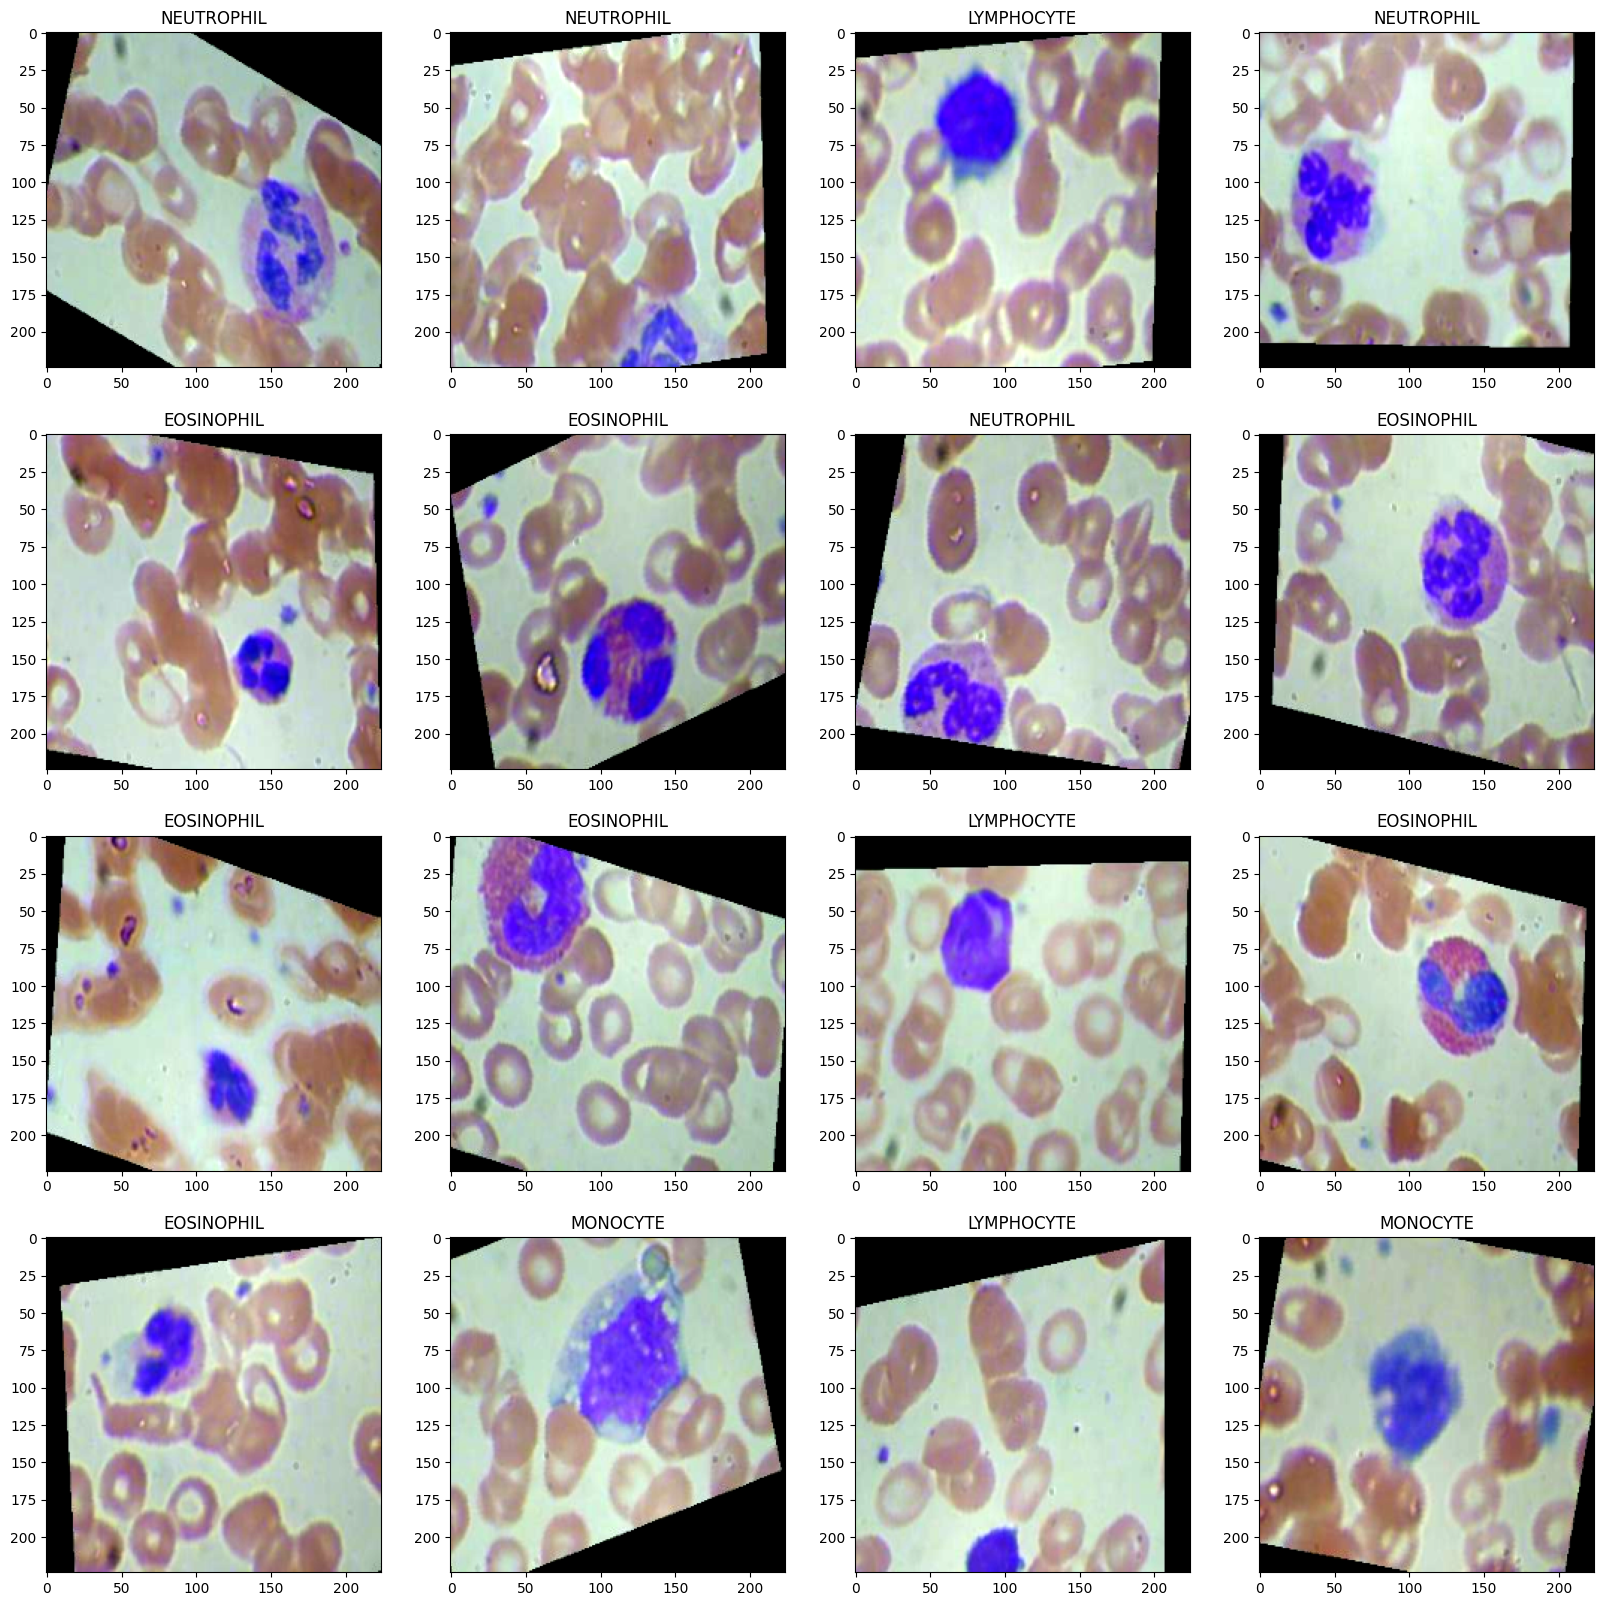

In [12]:
# Se ven algunas imágenes que se utilizan en entrenamiento.
# Se utiliza una adaptación de una función encontrada en página: https://www.guru99.com/transfer-learning.html

images, labels = next(iter(dataloaders['train']))
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
rows = 4
columns = 4
fig=plt.figure(figsize=(20,20))
for i in range(16):
   fig.add_subplot(rows, columns, i+1)
   plt.title(train_file.classes[labels[i]])
   img = images[i].numpy().transpose((1, 2, 0))
   img = std * img + mean
   plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

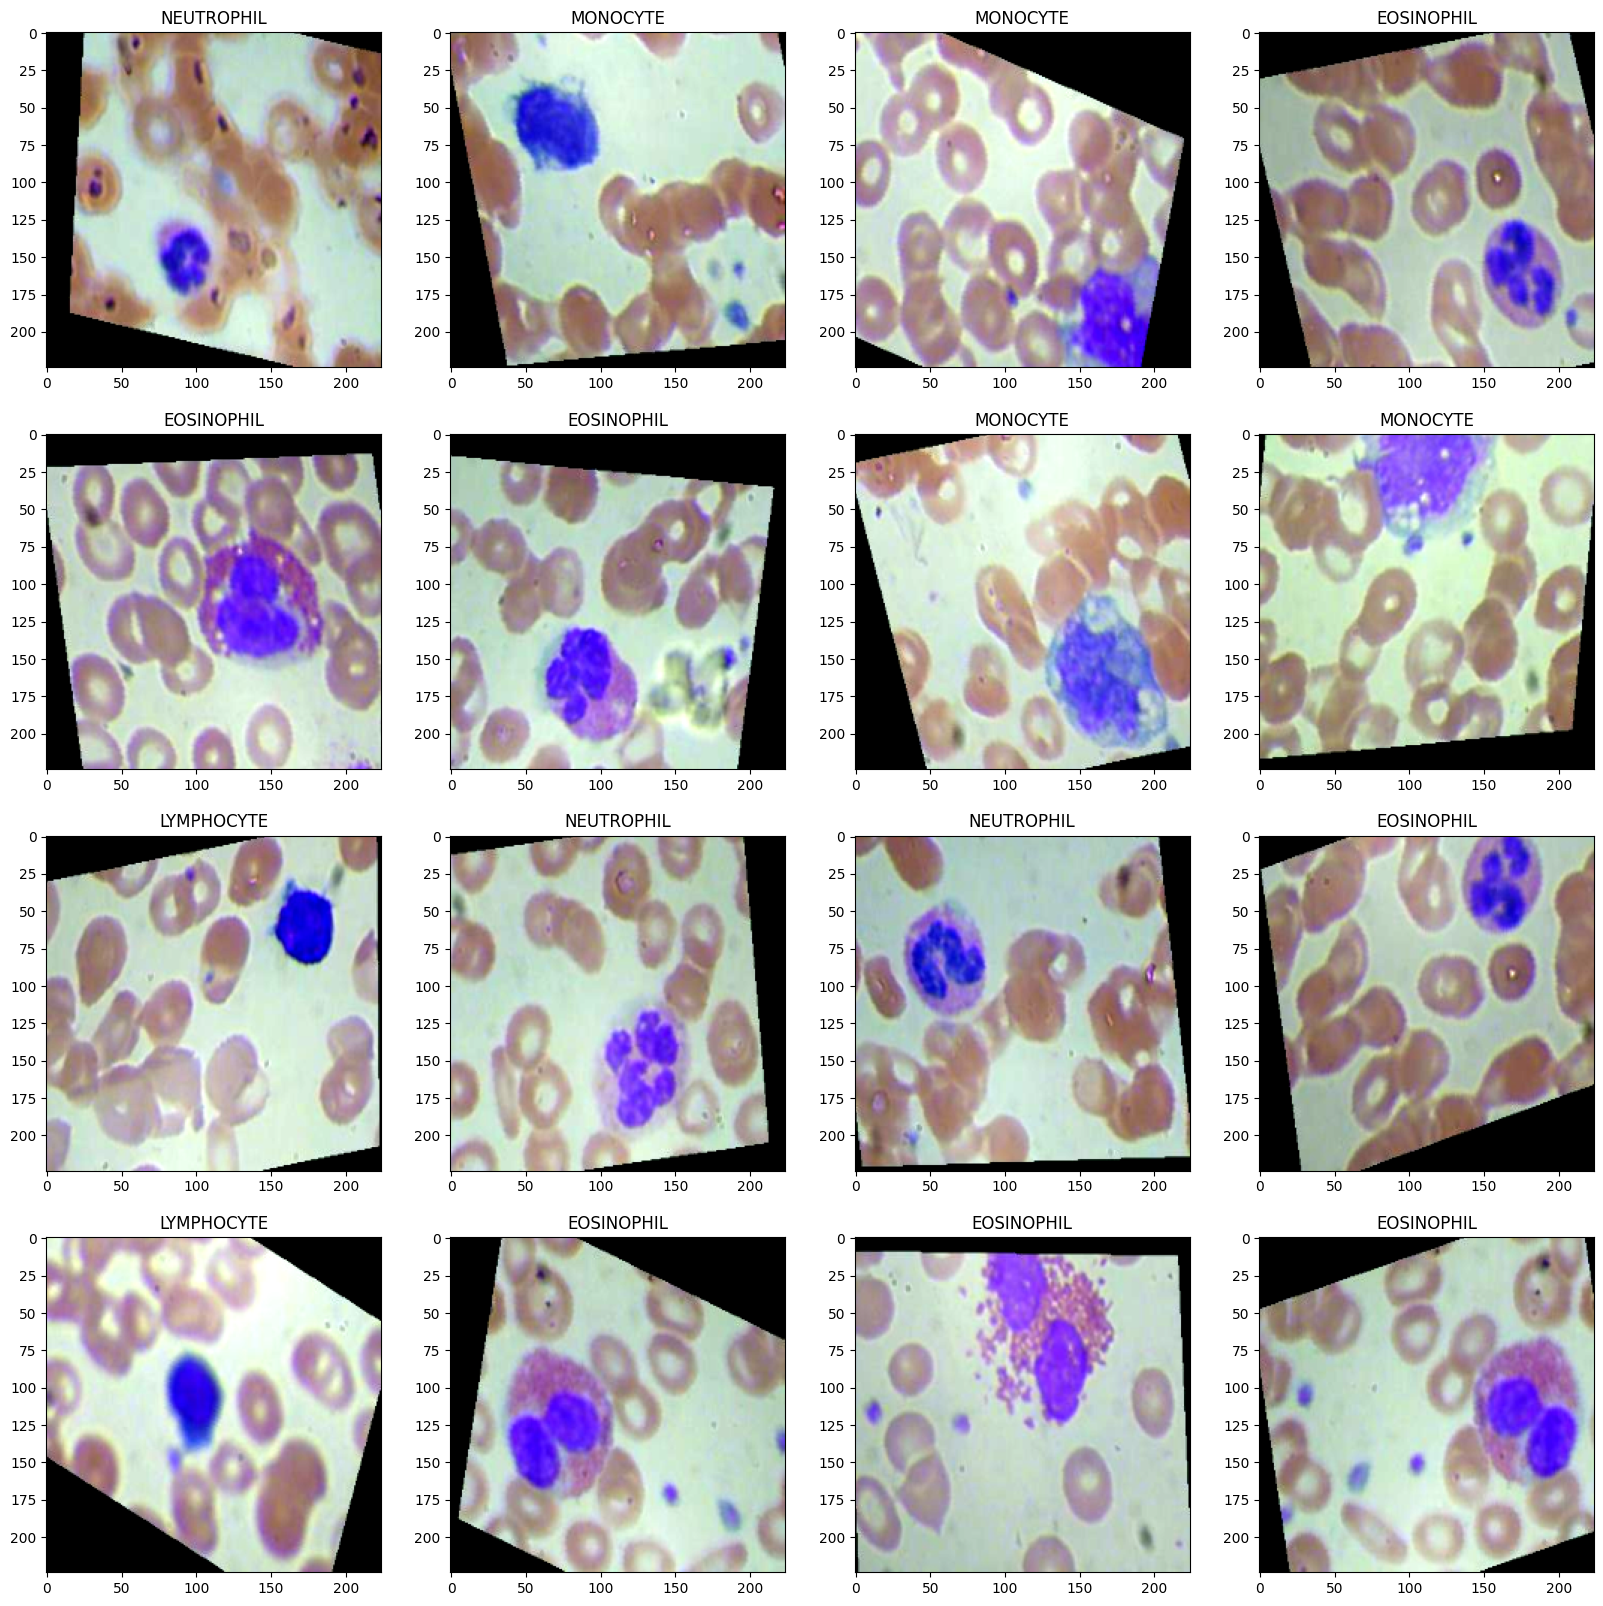

In [13]:
images, labels = next(iter(dataloaders['train_aug']))
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
rows = 4
columns = 4
fig=plt.figure(figsize=(20,20))
for i in range(16):
   fig.add_subplot(rows, columns, i+1)
   plt.title(train_file.classes[labels[i]])
   img = images[i].numpy().transpose((1, 2, 0))
   img = std * img + mean
   plt.imshow(img)
plt.show()

### Funciones


In [14]:
#Para evitar el overfitting, dado una tolerancia en épocas.
def earlyStop(train_loss, valid_loss, train_loss_epoch, valid_loss_epoch, patience):
  ntrain = len(train_loss_epoch)
  nvalid = len(valid_loss_epoch)
  average_train = 0
  average_valid = 0
  counter = 0

  if ntrain < patience:
    average_train = np.average(train_loss_epoch)
    average_valid = np.average(valid_loss_epoch)

  if ntrain >= patience:
    ntrain -= 1
    nvalid -= 1
    while counter != patience:
      average_train += train_loss_epoch[ntrain]
      average_valid += valid_loss_epoch[nvalid]
      ntrain -= 1
      nvalid -= 1
      counter +=1
    average_train = average_train/(patience)
    average_valid = average_valid/(patience)
  
  if (train_loss <= average_train) and (valid_loss > average_valid):  # detener, guardar checkpoint
    return True

  else: return False

In [15]:
def train_model2(num_epoch, model, dataloader, batchsize, dataaugmentation, criterion, optimizer, filepath, avg, n_save):
  global device

  train_losses = []       # to track the training loss as the model trains
  valid_losses = []       # to track the validation loss as the model trains
  
  avg_train_losses = []   # to track the average training loss per epoch as the model trains
  avg_valid_losses = []   # to track the average validation loss per epoch as the model trains

  if dataaugmentation == False:
    dataloader_val = dataloader['val'] 
    dataloader_train = dataloader['train'] 
  else:
    dataloader_val = dataloader['val']
    dataloader_train = dataloader['train_aug']

  for epoch in range(num_epoch):
      #if dataaugmentation == True:
      #  dataloader_val = dataloader['val']
      #  dataloader_train = dataloader['train_aug']
      try:
        model.train()

        # Train on the current epoch
        for x_train, y_train in dataloader_train:
            inputs = x_train.to(device)
            labels = y_train.to(device).long()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels).cuda()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Compute validation loss and accuracy for current epoch
        model.eval()
        with torch.no_grad():  
          for x_val, y_val in dataloader_val:
              inputs = x_val.to(device)
              labels = y_val.to(device).long()

              outputs = model(inputs)
              # Calcular loss de validación
              loss = criterion(outputs, labels).cuda()
              # record validation loss
              valid_losses.append(loss.item())

        # No se debe guardar checkpoints en cada época (guardarlos cada 50 épocas)
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # limpiar listas para la proxima epoca:
        train_losses = []
        valid_losses = []

        # imprimir resultados por epoca:  
        sys.stdout.write(f"\rÉpoca: {epoch} Training Loss: {train_loss} Validation Loss: {valid_loss}")

        # stop = earlyStop(train_loss, valid_loss, avg_train_losses, avg_valid_losses, avg)
        
        # if  stop == True:  # caso en que hay que deterner
        #     # cargar checkpoint, o guardar
        #     print(" - Early stopping")
        #     break

        # condición de checkpoint:
        if (epoch % n_save) == 0:
          torch.save(model.state_dict(), filepath)     
      
      # Interrupt Training
      except KeyboardInterrupt:
        print("\nEntrenamiento interrumpido")
        break

  # load the last checkpoint with the best model
  model.load_state_dict(torch.load(filepath))

  print('\nEntrenamiento finalizado')
  return model, avg_train_losses, avg_valid_losses

In [16]:
def predict(model, dataloader, plot_title):
  global device
  label_real = []
  pred_model = []
  model.eval()
  with torch.no_grad():
    #for x,y in enumerate(dataloader, 0):
    for x,y in dataloader:
      inputs = x.to(device)
      labels = y.to(device)#.long()

      outputs= model(inputs)
      pred = torch.argmax(outputs, 1)

      label_real = np.concatenate((label_real, labels.cpu().numpy()), axis=None)
      pred_model = np.concatenate((pred_model, pred.cpu().numpy()), axis=None)
      
  CM = confusion_matrix(label_real, pred_model, normalize= 'true')
  plt.figure(figsize = (10,7))
  sn.heatmap(CM, annot=True)
  plt.xlabel("Predicción")
  plt.ylabel("Observación")
  plt.title(plot_title)

  accuracy = accuracy_score(label_real, pred_model, normalize=True)
  print(f'accuracy: {accuracy}')
  return accuracy

In [17]:
def accuracy(y_pred, y_real):
  valor, posicion = torch.max(y_pred, dim = 1)
  pred = (posicion == y_real).float()
  accuracy = pred.sum()/len(pred)
  return accuracy

#### Gráficos

In [18]:
def plot(validation,train, plot_title):
  #minposs = validation.index(min(validation))+1 
  #plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')  # sirve para ver más o menos donde se tiene que detener
  #plt.title('Curva Loss - Epoch')
  plt.figure(figsize = (10,7))
  plt.plot(train, label='Train Loss')
  plt.plot(validation, label='Validation Loss')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(plot_title)

In [19]:
def curvas_loss(early_epoca, perdidas_train, perdidas_val):
  try:
    plt.plot([e for e in range(early_epoca+1)], perdidas_train, label='Entrenamiento')
    plt.plot([e for e in range(early_epoca+1)], perdidas_val, label='Validacion')
  except:
    plt.plot([e for e in range(early_epoca)], perdidas_train, label='Entrenamiento')
    plt.plot([e for e in range(early_epoca)], perdidas_val, label='Validacion')
  plt.xlabel('Epocas')
  plt.ylabel('Valor')
  plt.title(f'Perdidas de entrenamiento/validacion para el modelo')
  plt.legend()
  plt.show()

#### MOdelo Resnet

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [21]:
class ResNet34(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet34, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# class Net(nn.Module):
    
    
#     # Defining the Constructor
#     def __init__(self, num_classes=3):
#         super(Net, self).__init__()
       
#         # In the init function, we define each layer we will use in our model
        
#         # Our images are RGB, so we have input channels = 3. 
#         # We will apply 12 filters in the first convolutional layer
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
#         # A second convolutional layer takes 12 input channels, and generates 24 outputs
#         self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
#         # We in the end apply max pooling with a kernel size of 2
#         self.pool = nn.MaxPool2d(kernel_size=2)
        
#         # A drop layer deletes 20% of the features to help prevent overfitting
#         self.drop = nn.Dropout2d(p=0.2)
        
#         # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
#         # This means that our feature tensors are now 32 x 32, and we've generated 24 of them
        
#         # We need to flatten these in order to feed them to a fully-connected layer
#         self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

#     def forward(self, x):
#         # In the forward function, pass the data through the layers we defined in the init function
        
#         # Use a ReLU activation function after layer 1 (convolution 1 and pool)
#         x = F.relu(self.pool(self.conv1(x))) 
        
#         # Use a ReLU activation function after layer 2
#         x = F.relu(self.pool(self.conv2(x)))  
        
#         # Select some features to drop to prevent overfitting (only drop during training)
#         x = F.dropout(self.drop(x), training=self.training)
        
#         # Flatten
#         x = x.view(-1, 32 * 32 * 24)
#         # Feed to fully-connected layer to predict class
#         x = self.fc(x)
#         # Return class probabilities via a log_softmax function 
#         return torch.log_softmax(x, dim=1) 

# Entrenar Modelo

## Con Data Augmentation

In [23]:
# model_ft = models.resnet18(weights='ResNet18_Weights.DEFAULT') #models.resnet18(pretrained=True)

# # for param in model_ft.parameters():
# #    param.requires_grad = True

# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, len(train_file.classes))
# for param in model_ft.parameters():
#    param.requires_grad = True

# criterion = nn.CrossEntropyLoss()
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3) #SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
# model_ft = ResNet34(3, ResBlock, outputs=4) #models.resnet18(pretrained=True)
# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [25]:
# model_ft2 = Net() 
model_ft2 = ResNet34(ResidualBlock, [3, 4, 6, 3], num_classes=4) #ResNet34(3, ResBlock, outputs=4) #models.resnet18(pretrained=True)

#model_ft2 = copy.deepcopy(model_ft)
model_ft2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft2.parameters(), lr=1e-3)

num_epochs = 30
batch_size = 150
n_save = 5
avg = 10
data_augmentation = True
file_path = 'model_ft18_DA.pth'

model_ft_trained = train_model2(num_epochs, model_ft2, dataloaders, batch_size, data_augmentation, criterion, optimizer_ft, file_path, avg, n_save)

Época: 8 Training Loss: 0.11139373663956156 Validation Loss: 6.1604623794555665
Entrenamiento interrumpido

Entrenamiento finalizado


accuracy: 0.27744270205066346


0.27744270205066346

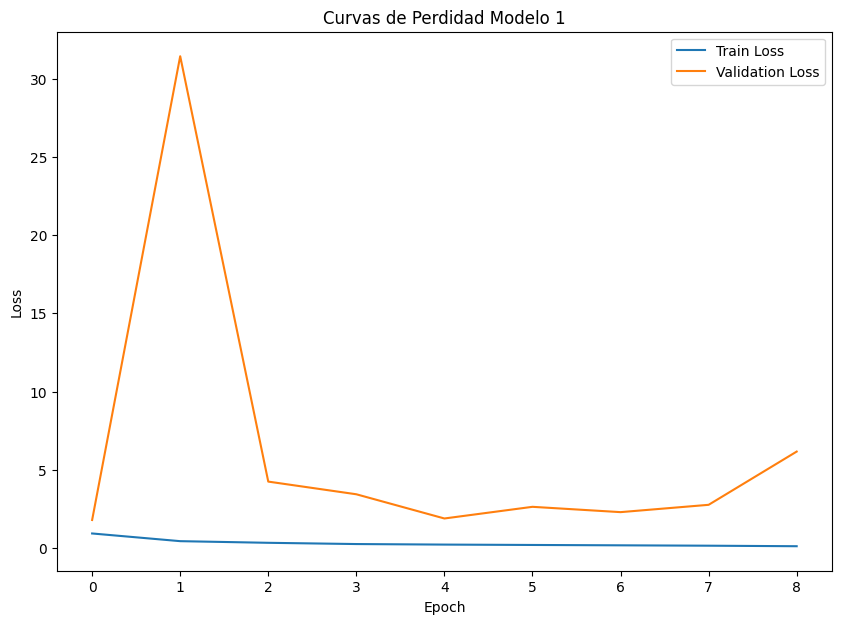

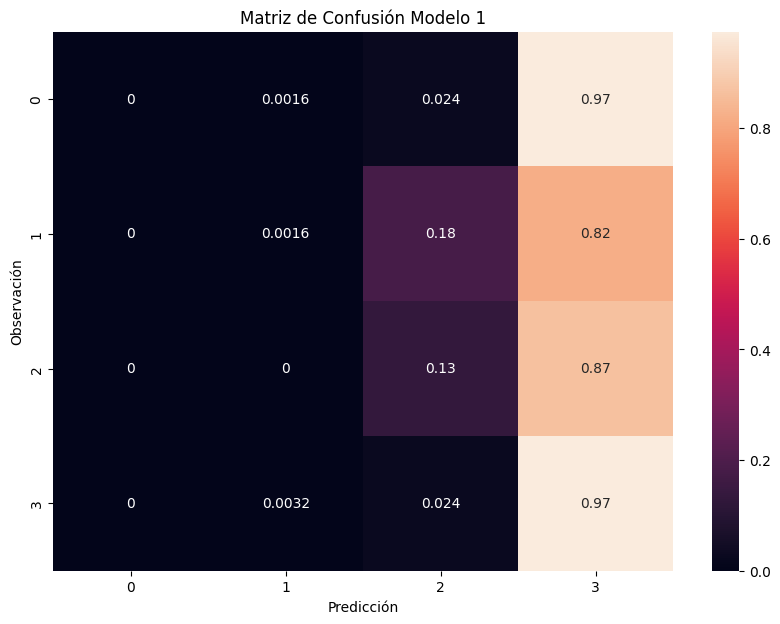

In [26]:
plot(model_ft_trained[2], model_ft_trained[1],'Curvas de Perdidad Modelo 1')
predict(model_ft_trained[0], dataloaders['test'], 'Matriz de Confusión Modelo 1')

## Sin Data Augmentation

In [30]:
model_ft3 = models.resnet18(pretrained=True)
num_ftrs = model_ft3.fc.in_features
model_ft3.fc = nn.Linear(num_ftrs, len(train_file.classes))
for param in model_ft3.parameters():
   param.requires_grad = False
model_ft3.to(device)

criterion3 = nn.CrossEntropyLoss()
optimizer_ft3 = optim.Adam(model_ft3.parameters(), lr=1e-3)

num_epochs = 25
batch_size = 150
n_save = 5
avg = 10
data_augmentation = False
file_path = 'model_ft18_sinDA.pth'

model_ft_trained_sinDA = train_model2(num_epochs, model_ft3, dataloaders, batch_size, data_augmentation, criterion3, optimizer_ft3, file_path, avg, n_save)

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

accuracy: 0.27020506634499397


0.27020506634499397

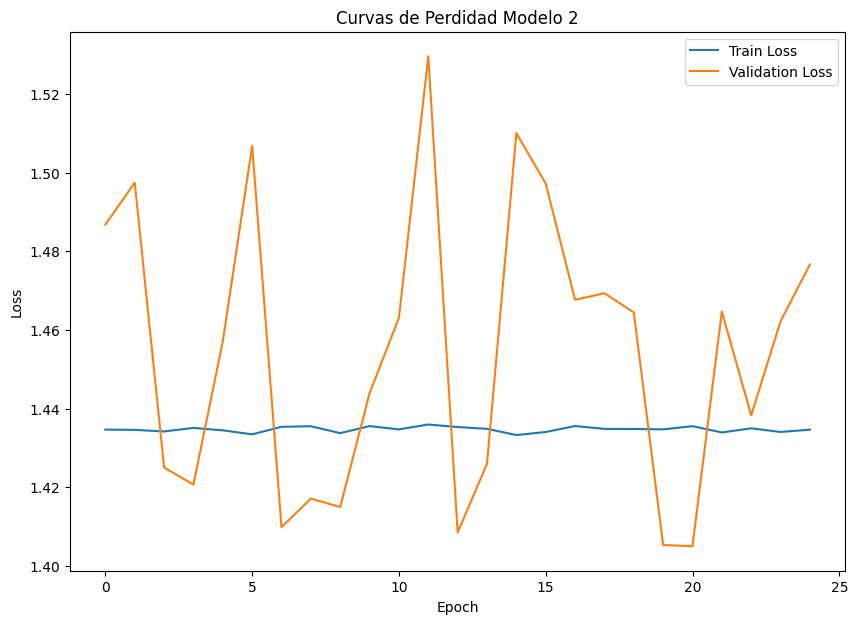

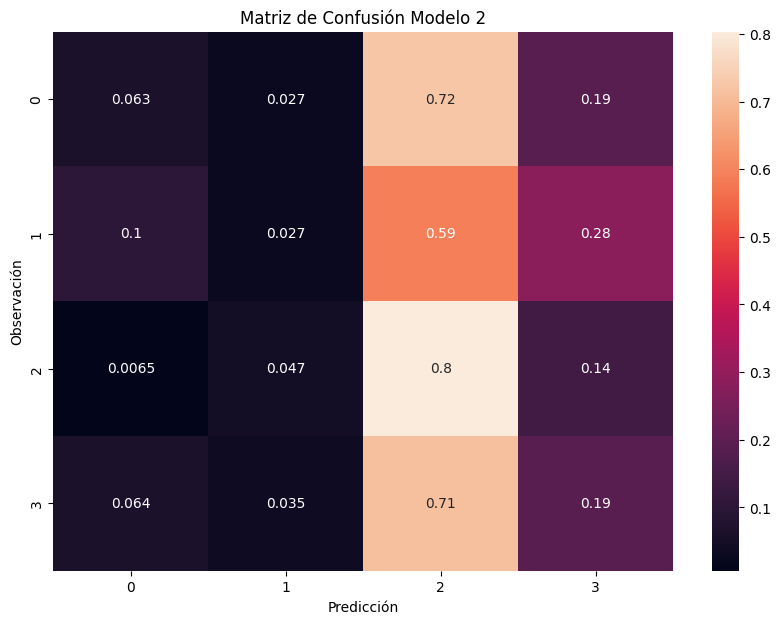

In [ ]:
plot(model_ft_trained_sinDA[2], model_ft_trained_sinDA[1],'Curvas de Perdidad Modelo 2')
predict(model_ft_trained_sinDA[0], dataloaders['test'], 'Matriz de Confusión Modelo 2')